# CNN-TL | WITHOUT TRANSFER LEARNING
## Loading UNSW-NB15 Datasets

In [1]:
# Imports
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn theme to the plots
sns.set()

# 1. UNSW-NB15-Train-Basic for training and UNSW-NB15-Test-Basic for validation


In [2]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [3]:
# Load UNSW-NB15-Test-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Test-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [4]:
# Model building and definition
input_shape = (24,1,1)
model = models.Sequential()
model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Flatten())
model.add(Dense(444, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 1, 32)         352       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 1, 64)         20544     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 1, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 444)               682428    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8

In [ ]:
# Early Stopping
filepath = '../models/tmp/1_Train-Basic_Test-Basic_Detection.hdf5' # define where the model is saved

callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 10 # Stop after 10 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [ ]:
#Configure model training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=2048, callbacks=callbacks)
history1=history

Epoch 1/15
201/201 [==============================] - 41s 203ms/step - loss: 0.1089 - accuracy: 0.9697 - val_loss: 0.0338 - val_accuracy: 0.9918
Epoch 2/15
201/201 [==============================] - 39s 194ms/step - loss: 0.0310 - accuracy: 0.9920 - val_loss: 0.0286 - val_accuracy: 0.9923
Epoch 3/15
201/201 [==============================] - 39s 194ms/step - loss: 0.0283 - accuracy: 0.9922 - val_loss: 0.0276 - val_accuracy: 0.9924
Epoch 4/15
201/201 [==============================] - 39s 192ms/step - loss: 0.0272 - accuracy: 0.9923 - val_loss: 0.0271 - val_accuracy: 0.9924
Epoch 5/15
201/201 [==============================] - 39s 195ms/step - loss: 0.0267 - accuracy: 0.9923 - val_loss: 0.0264 - val_accuracy: 0.9924
Epoch 6/15
201/201 [==============================] - 38s 192ms/step - loss: 0.0266 - accuracy: 0.9923 - val_loss: 0.0289 - val_accuracy: 0.9924
Epoch 7/15
201/201 [==============================] - 44s 218ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.0265 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


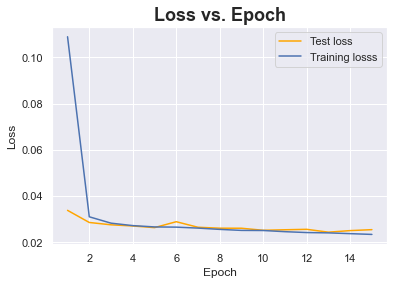

In [ ]:
# summarize history for accuracy
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

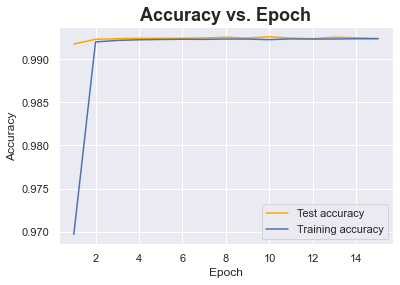

In [ ]:
# summarize history for loss
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

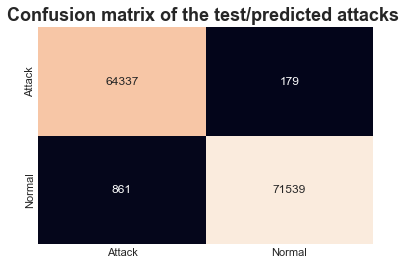

In [ ]:
# Prediction
predicted = model.predict(x_test)

# Confusion matrix
y_class = np.argmax(predicted, axis = 1) 
y_test=y_test.to_numpy()
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

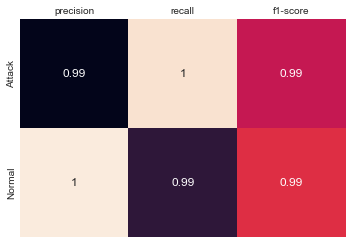

In [ ]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=False, annot=True)
plt.show()

In [ ]:
# Showing more detailed view of Precision, Recall & F1-Score
class_rep

{'Attack': {'precision': 0.9867940734378355,
  'recall': 0.9972254944509888,
  'f1-score': 0.9919823611946282,
  'support': 64516},
 'Normal': {'precision': 0.9975041133327756,
  'recall': 0.9881077348066298,
  'f1-score': 0.9927836911419808,
  'support': 72400},
 'accuracy': 0.9924041017850361,
 'macro avg': {'precision': 0.9921490933853055,
  'recall': 0.9926666146288093,
  'f1-score': 0.9923830261683045,
  'support': 136916},
 'weighted avg': {'precision': 0.9924574501680472,
  'recall': 0.9924041017850361,
  'f1-score': 0.9924060975599057,
  'support': 136916}}

## Analysing Attack Detection

### Code

In [ ]:
predicted

array([[9.9311358e-01, 6.8863560e-03],
       [9.9870086e-01, 1.2991070e-03],
       [9.9376041e-01, 6.2395972e-03],
       ...,
       [6.9779481e-11, 1.0000000e+00],
       [9.9869943e-01, 1.3005505e-03],
       [6.7757675e-08, 9.9999988e-01]], dtype=float32)

In [ ]:
df = pd.DataFrame(predicted)
df.index = data.index

In [ ]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [ ]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [ ]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [ ]:
data['attack_cat'].value_counts()

normal            72400
generic           53677
exploits           6948
reconnaissance     2942
dos                 949
Name: attack_cat, dtype: int64

In [ ]:
normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [ ]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [ ]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [ ]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.19 % of NO detected and 98.81 % of detected samples


In [ ]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.07 % of NO detected and 99.93 % of detected samples


In [ ]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 1.47 % of NO detected and 98.53 % of detected samples


In [ ]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.37 % of NO detected and 99.63 % of detected samples


In [ ]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 2.74 % of NO detected and 97.26 % of detected samples


In [ ]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [ ]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [ ]:
data_plot=dff[['category', 'category_pred']]

In [ ]:
data_plot

,category,category_pred
0,generic,Detected
1,generic,Detected
2,generic,Detected
4,normal,Detected
5,normal,Detected
...,...,...
145168,normal,Detected
145169,generic,Detected
145170,normal,Detected
145171,generic,Detected


### Results

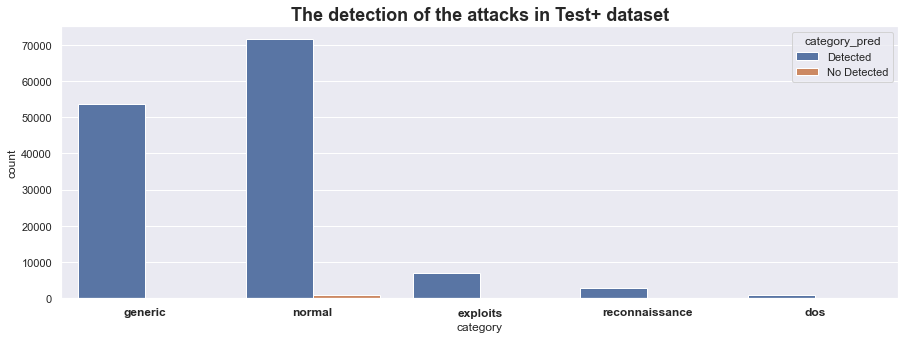

In [ ]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [ ]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.810773,1.189227,71539,861
1,Generic,99.925480,0.074520,53637,40
2,Exploits,98.531952,1.468048,6846,102
3,Reconnaissance,99.626105,0.373895,2931,11
4,DoS,97.260274,2.739726,923,26


# 2. UNSW-NB15-Train-Basic for training and UNSW-NB15-Test+ for validation

In [ ]:
# Load UNSW-NB15-Train-Basic
data = pd.read_csv('../datasets/UNSW-NB15-Train-Basic.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

# Drop the invalid features and select interested data features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_train, y_train=data_features, data_labels

In [ ]:
# Load UNSW-NB15-Test+
data = pd.read_csv('../datasets/UNSW-NB15-Test+.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Generate 4 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(21, 'state_PAR', auxCol, True)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [ ]:
# Model building and definition
input_shape = (24,1,1)
model = models.Sequential()
model.add(layers.Conv2D(filters=32,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Conv2D(filters=64,  input_shape=input_shape, kernel_size=(1,10), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(1, 2), padding='same'))
model.add(layers.Flatten())
model.add(Dense(444, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 1, 32)         352       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 1, 64)         20544     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 1, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 444)               682428    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8

In [ ]:
# Early Stopping
filepath = '../models/tmp/2_Train-Basic_Test+_Detection.hdf5' # define where the model is saved

callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', # Use accuracy to monitor the model
            patience = 15 # Stop after 15 steps with lower accuracy
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, # file where the checkpoint is saved
            monitor = 'val_loss', # Don't overwrite the saved model unless val_loss is worse
            save_best_only = True)]# Only save model if it is the best

In [ ]:
#Configure model training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=2048, callbacks=callbacks)
history2=history

Epoch 1/15
201/201 [==============================] - 42s 205ms/step - loss: 0.1193 - accuracy: 0.9653 - val_loss: 0.0572 - val_accuracy: 0.9903
Epoch 2/15
201/201 [==============================] - 44s 217ms/step - loss: 0.0307 - accuracy: 0.9921 - val_loss: 0.0758 - val_accuracy: 0.9866
Epoch 3/15
201/201 [==============================] - 38s 190ms/step - loss: 0.0278 - accuracy: 0.9922 - val_loss: 0.1426 - val_accuracy: 0.9612
Epoch 4/15
201/201 [==============================] - 39s 195ms/step - loss: 0.0269 - accuracy: 0.9923 - val_loss: 0.2812 - val_accuracy: 0.8473
Epoch 5/15
201/201 [==============================] - 43s 214ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.3619 - val_accuracy: 0.8190
Epoch 6/15
201/201 [==============================] - 40s 197ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.4103 - val_accuracy: 0.8051
Epoch 7/15
201/201 [==============================] - 38s 190ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.4510 - val_ac

In [ ]:
#model.save('../models/UNSW-NB15_NON-TF.hdf5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


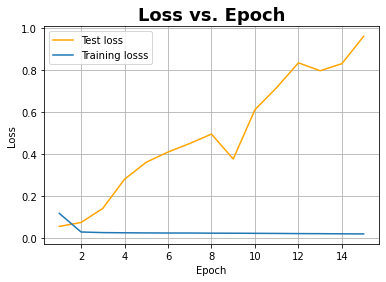

In [ ]:
# summarize history for accuracy
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training losss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

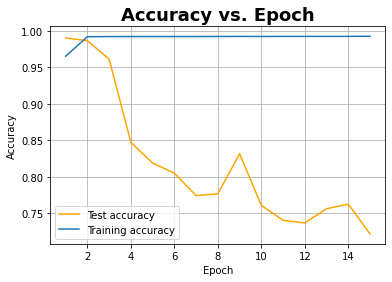

In [ ]:
# summarize history for loss
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

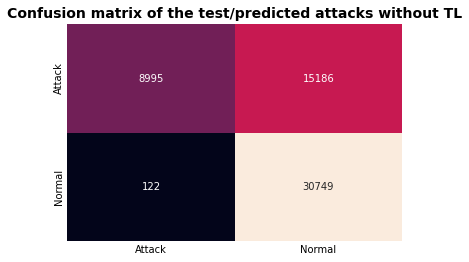

In [ ]:
# Prediction
predicted = model.predict(x_test)

# Confusion matrix
y_class = np.argmax(predicted, axis = 1) 
y_test=y_test.to_numpy()
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix of the test/predicted attacks without TL', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

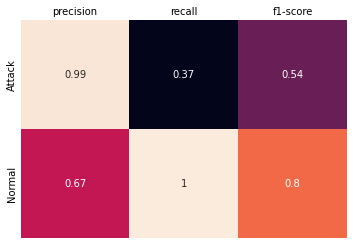

In [ ]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=False, annot=True)
plt.show()

In [ ]:
class_rep

{'Attack': {'precision': 0.9866184051771416,
  'recall': 0.37198627021215,
  'f1-score': 0.5402726890503934,
  'support': 24181},
 'Normal': {'precision': 0.6694024164580386,
  'recall': 0.9960480710051505,
  'f1-score': 0.8006926542197225,
  'support': 30871},
 'accuracy': 0.7219356245004723,
 'macro avg': {'precision': 0.8280104108175901,
  'recall': 0.6840171706086502,
  'f1-score': 0.6704826716350579,
  'support': 55052},
 'weighted avg': {'precision': 0.8087361340925774,
  'recall': 0.7219356245004723,
  'f1-score': 0.6863059802067975,
  'support': 55052}}

## Analysing Attack Detection

### Code

In [ ]:
predicted

array([[9.0375528e-02, 9.0962452e-01],
       [3.7101716e-02, 9.6289825e-01],
       [1.1245415e-01, 8.8754588e-01],
       ...,
       [5.5595357e-16, 1.0000000e+00],
       [3.5036892e-19, 1.0000000e+00],
       [9.0872425e-14, 1.0000000e+00]], dtype=float32)

In [ ]:
df = pd.DataFrame(predicted)
df.index = data.index

In [ ]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [ ]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [ ]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [ ]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

In [ ]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']


In [ ]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

In [ ]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 0.40 % of NO detected and 99.60 % of detected samples


In [ ]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 51.93 % of NO detected and 48.07 % of detected samples


In [ ]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 80.39 % of NO detected and 19.61 % of detected samples


In [ ]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 64.89 % of NO detected and 35.11 % of detected samples


In [ ]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 36.27 % of NO detected and 63.73 % of detected samples


In [ ]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 37.93 % of NO detected and 62.07 % of detected samples


In [ ]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0]})

In [ ]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [ ]:
data_plot=dff[['category', 'category_pred']]

In [ ]:
data_plot

,category,category_pred
4,fuzzers,No Detected
5,fuzzers,No Detected
6,fuzzers,No Detected
7,fuzzers,No Detected
8,fuzzers,No Detected
...,...,...
61869,normal,Detected
61870,normal,Detected
61871,normal,Detected
61872,normal,Detected


### Results

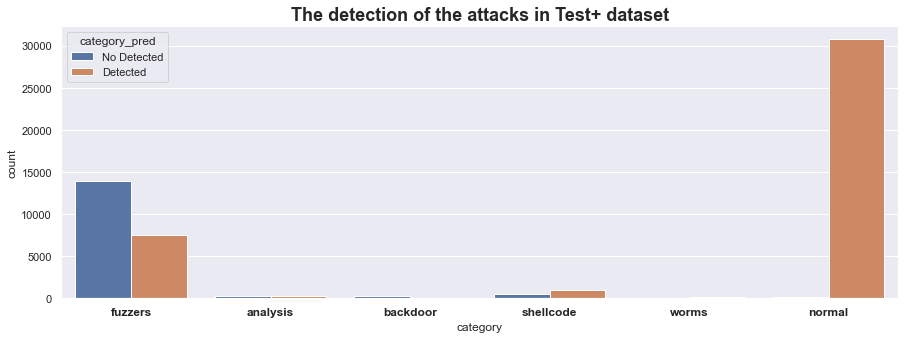

In [ ]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [ ]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,99.604807,0.395193,30749,122
1,Analysis,48.070740,51.929260,299,323
2,Backdoor,19.607843,80.392157,70,287
3,Fuzzers,35.111772,64.888228,7555,13962
4,Shellcode,63.732627,36.267373,963,548
5,Worms,62.068966,37.931034,108,66


In [ ]:
summary.to_csv('../others/No_TransferLearning.csv', index=False)

## Comparision between Basic-Test and Test+

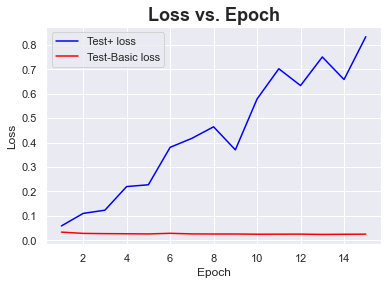

In [ ]:
# summarize history for accuracy
loss_1 = history1.history['val_loss']
loss_2 = history2.history['val_loss']
x = list(range(1, len(loss_1) + 1))
plt.plot(x, loss_2, color = 'blue', label = 'Test+ loss')
plt.plot(x, loss_1, color = 'red', label = 'Test-Basic loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

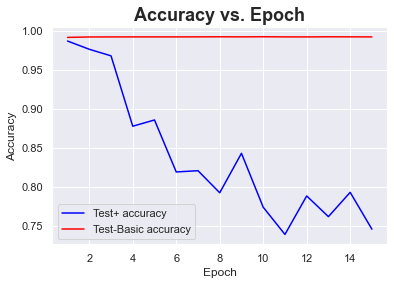

In [ ]:
# summarize history for loss
acc_1 = history1.history['val_accuracy']
acc_2 = history2.history['val_accuracy']
x = list(range(1, len(acc_1) + 1))
plt.plot(x, acc_2, color = 'blue', label = 'Test+ accuracy')
plt.plot(x, acc_1, color = 'red', label = 'Test-Basic accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

# 3. UNSW-NB15-Train-Basic for training and UNSW-NB15 for validation

In [ ]:
# Load UNSW-NB15
data = pd.read_csv('../datasets/UNSW-NB15-Test.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='ipv6-icmp') | (data['proto'] =='igmp') | (data['proto'] =='rarp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['label']]

#Extracting dataset features
data_features=data[['proto','srcip','sport','dstip','dsport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

In [ ]:
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(".")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: x.split(":")[-1])
data_features['srcip'] = data_features['srcip'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(".")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: x.split(":")[-1])
data_features['dstip'] = data_features['dstip'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dsport'] = data_features['dsport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dsport'] = data_features['dsport'].replace('-', -1)
data_features['dsport'] = data_features['dsport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dsport'] = data_features['dsport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['srcip'] = data_features['srcip'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['dstip'] = data_features['dstip'].astype(int)
data_features['dsport'] = data_features['dsport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)
    
# Create a complementary field of attack & Transform to One hot encoding - LABELS
normal=data_labels['label']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)

# Insert the new column in data labels
data_labels.insert(1, 'normal', normal)
data_labels = pd.get_dummies(data_labels)

# Transform to One hot encoding - FEATURES
data_features=pd.get_dummies(data_features)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)
data_features = np.expand_dims(data_features, axis=3)

x_test, y_test=data_features, data_labels

In [ ]:
x_test.shape

(2495843, 24, 1, 1)

In [ ]:
# Load Transfer Learning model
modelFE = load_model('../models/UNSW-NB15_NON-TF.hdf5')

In [ ]:
#Evaluate the model
results = model.evaluate(x_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [0.6559886336326599, 0.8537527918815613]


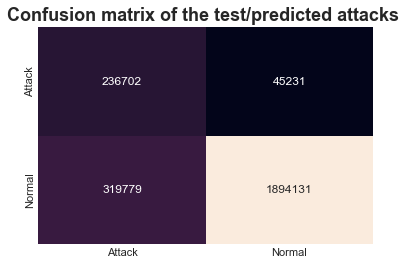

In [ ]:
# Prediction
predicted = model.predict(x_test)

# Confusion matrix
y_class = np.argmax(predicted, axis = 1)
y_test1=y_test
y_test1=y_test1.to_numpy()
y_check = np.argmax(y_test1, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)

cmatrix_df = pd.DataFrame(cmatrix, index = ['Attack', 'Normal'], columns = ['Attack', 'Normal'])
plt.title('Confusion matrix of the test/predicted attacks ', weight='bold', fontsize=18)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False)
plt.show()

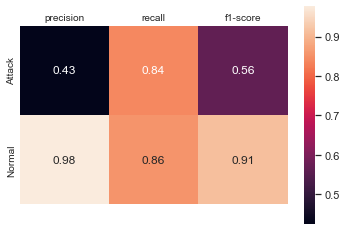

In [ ]:
# Precision, Recall & F1-Score
class_rep = classification_report(y_check, y_class, target_names = ['Attack', 'Normal'], output_dict=True)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :-3].T, square=True, cbar=True, annot=True)
plt.show()

In [ ]:
# Precision, Recall & F1-Score
FPR, TPR, THRESHOLD = metrics.roc_curve(y_check, y_class)

In [ ]:
FPR[1]

0.16043173378072095

In [ ]:
class_rep

{'Attack': {'precision': 0.42535504356842374,
  'recall': 0.839568266219279,
  'f1-score': 0.5646422888930767,
  'support': 281933},
 'Normal': {'precision': 0.9766773815306271,
  'recall': 0.8555591690719135,
  'f1-score': 0.9121150745725298,
  'support': 2213910},
 'accuracy': 0.8537528201894109,
 'macro avg': {'precision': 0.7010162125495254,
  'recall': 0.8475637176455963,
  'f1-score': 0.7383786817328033,
  'support': 2495843},
 'weighted avg': {'precision': 0.9143994414884459,
  'recall': 0.8537528201894109,
  'f1-score': 0.872864190248089,
  'support': 2495843}}

## Analysing Attack Detection

### Code

In [ ]:
predicted

array([[3.6180351e-04, 9.9963820e-01],
       [9.6068311e-01, 3.9316952e-02],
       [5.1086041e-04, 9.9948907e-01],
       ...,
       [2.7438837e-01, 7.2561169e-01],
       [8.8625019e-12, 1.0000000e+00],
       [7.1627921e-01, 2.8372082e-01]], dtype=float32)

In [ ]:
df = pd.DataFrame(predicted)
df.index = data.index

In [ ]:
df['attack']=data['label']
df['category']=data['attack_cat']
df['normal']=data_labels['normal']

In [ ]:
df.columns = ['pred_attack', 'pred_normal', 'attack', 'category', 'normal']

In [ ]:
dff=df
df=pd.get_dummies(df)
df=round(df)

In [ ]:
analysis=df.loc[df['category_analysis'] == 1]
analysis=analysis[['pred_attack', 'pred_normal', 'attack', 'normal']]
analysis_pred=analysis[['pred_attack','pred_normal']]
analysis_check=analysis[['attack','normal']]

backdoor=df.loc[df['category_backdoor'] == 1]
backdoor=backdoor[['pred_attack', 'pred_normal', 'attack', 'normal']]
backdoor_pred=backdoor[['pred_attack','pred_normal']]
backdoor_check=backdoor[['attack','normal']]

fuzzers=df.loc[df['category_fuzzers'] == 1]
fuzzers=fuzzers[['pred_attack', 'pred_normal', 'attack', 'normal']]
fuzzers_pred=fuzzers[['pred_attack','pred_normal']]
fuzzers_check=fuzzers[['attack','normal']]

normal=df.loc[df['category_normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

shellcode=df.loc[df['category_shellcode'] == 1]
shellcode=shellcode[['pred_attack', 'pred_normal', 'attack', 'normal']]
shellcode_pred=shellcode[['pred_attack','pred_normal']]
shellcode_check=shellcode[['attack','normal']]

worms=df.loc[df['category_worms'] == 1]
worms=worms[['pred_attack', 'pred_normal', 'attack', 'normal']]
worms_pred=worms[['pred_attack','pred_normal']]
worms_check=worms[['attack','normal']]

generic=df.loc[df['category_generic'] == 1]
generic=generic[['pred_attack', 'pred_normal', 'attack', 'normal']]
generic_pred=generic[['pred_attack','pred_normal']]
generic_check=generic[['attack','normal']]

exploits=df.loc[df['category_exploits'] == 1]
exploits=exploits[['pred_attack', 'pred_normal', 'attack', 'normal']]
exploits_pred=exploits[['pred_attack','pred_normal']]
exploits_check=exploits[['attack','normal']]

reconnaissance=df.loc[df['category_reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df.loc[df['category_dos'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [ ]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
analysis_c = analysis['pred_attack'] * analysis['attack']
backdoor_c = backdoor['pred_attack'] * backdoor['attack']
fuzzers_c = fuzzers['pred_attack'] * fuzzers['attack']
shellcode_c = shellcode['pred_attack'] * shellcode['attack']
worms_c = worms['pred_attack'] * worms['attack']
generic_c = generic['pred_attack'] * generic['attack']
exploits_c = exploits['pred_attack'] * exploits['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [ ]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

analysis_c0 = (analysis_c == 0).sum()
analysis_c1 = len(analysis) - analysis_c0

backdoor_c0 = (backdoor_c == 0).sum()
backdoor_c1 = len(backdoor) - backdoor_c0

fuzzers_c0 = (fuzzers_c == 0).sum()
fuzzers_c1 = len(fuzzers) - fuzzers_c0

shellcode_c0 = (shellcode_c == 0).sum()
shellcode_c1 = len(shellcode) - shellcode_c0

worms_c0 = (worms_c == 0).sum()
worms_c1 = len(worms) - worms_c0

generic_c0 = (generic_c == 0).sum()
generic_c1 = len(generic) - generic_c0

exploits_c0 = (exploits_c == 0).sum()
exploits_c1 = len(exploits) - exploits_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [ ]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 14.44 % of NO detected and 85.56 % of detected samples


In [ ]:
analysis_0, analysis_1 = analysis_c0*100 / len(analysis), analysis_c1*100 / len(analysis)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(analysis_0, analysis_1))

There are 98.71 % of NO detected and 1.29 % of detected samples


In [ ]:
backdoor_0, backdoor_1 = backdoor_c0*100 / len(backdoor), backdoor_c1*100 / len(backdoor)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(backdoor_0, backdoor_1))

There are 78.99 % of NO detected and 21.01 % of detected samples


In [ ]:
fuzzers_0, fuzzers_1 = fuzzers_c0*100 / len(fuzzers), fuzzers_c1*100 / len(fuzzers)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(fuzzers_0, fuzzers_1))

There are 85.37 % of NO detected and 14.63 % of detected samples


In [ ]:
shellcode_0, shellcode_1 = shellcode_c0*100 / len(shellcode), shellcode_c1*100 / len(shellcode)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(shellcode_0, shellcode_1))

There are 30.97 % of NO detected and 69.03 % of detected samples


In [ ]:
worms_0, worms_1 = worms_c0*100 / len(worms), worms_c1*100 / len(worms)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(worms_0, worms_1))

There are 70.69 % of NO detected and 29.31 % of detected samples


In [ ]:
generic_0, generic_1 = generic_c0*100 / len(generic), generic_c1*100 / len(generic)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(generic_0, generic_1))

There are 0.84 % of NO detected and 99.16 % of detected samples


In [ ]:
exploits_0, exploits_1 = exploits_c0*100 / len(exploits), exploits_c1*100 / len(exploits)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(exploits_0, exploits_1))

There are 52.10 % of NO detected and 47.90 % of detected samples


In [ ]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 57.15 % of NO detected and 42.85 % of detected samples


In [ ]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 53.27 % of NO detected and 46.73 % of detected samples


In [ ]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "Analysis", "Backdoor", "Fuzzers", "Shellcode", "Worms", "Generic", "Exploits", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, analysis_1, backdoor_1, fuzzers_1, shellcode_1, worms_1, generic_1, exploits_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, analysis_0, backdoor_0, fuzzers_0, shellcode_0, worms_0, generic_0, exploits_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, analysis_c1, backdoor_c1, fuzzers_c1, shellcode_c1, worms_c1, generic_c1, exploits_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, analysis_c0, backdoor_c0, fuzzers_c0, shellcode_c0, worms_c0, generic_c0, exploits_c0, reconnaissance_c0, dos_c0]})

In [ ]:
dff['category_pred'] = np.where(((df['attack'] == 1) & (df['pred_attack'] == 1)) | ((df['normal'] == 1) & (df['pred_normal'] == 1)), 'Detected', 'No Detected')

In [ ]:
data_plot=dff[['category', 'category_pred']]

In [ ]:
data_plot

,category,category_pred
0,normal,Detected
1,normal,No Detected
2,normal,Detected
3,normal,Detected
4,normal,Detected
...,...,...
2540042,normal,Detected
2540043,normal,Detected
2540044,normal,Detected
2540045,normal,Detected


### Results

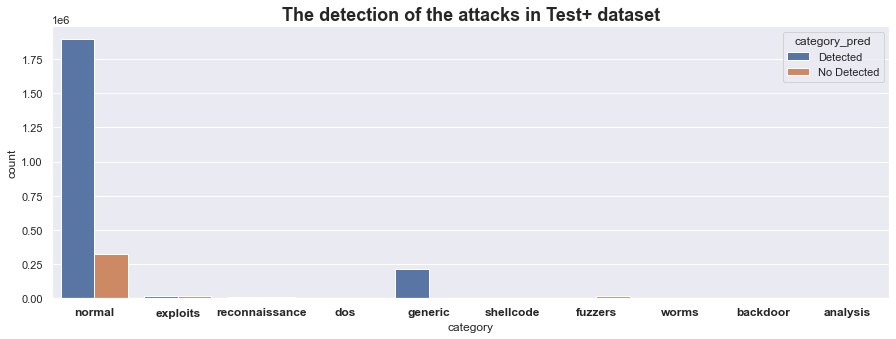

In [ ]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot, hue=data_plot['category_pred'])
plt.title('The detection of the attacks in Test+ dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [ ]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,85.555917,14.444083,1894131,319779
1,Analysis,1.286174,98.713826,8,614
2,Backdoor,21.008403,78.991597,75,282
3,Fuzzers,14.625645,85.374355,3147,18370
4,Shellcode,69.027134,30.972866,1043,468
5,Worms,29.310345,70.689655,51,123
6,Generic,99.163384,0.836616,211930,1788
7,Exploits,47.897023,52.102977,13563,14754
8,Reconnaissance,42.854733,57.145267,5080,6774
9,DoS,46.725343,53.274657,1805,2058


In [ ]:
summary.to_csv('../others/No_TransferLearningFull.csv', index=False)